# UNIVERSITA' DEGLI STUDI DI NAPOLI FEDERICO II
# NEURAL NETWORK AND DEEP LEARNING
## Authors

    Giuseppe Cicchella N97000452
    Raffaele D'Anna N97000455
    
# Confronto tra l’algoritmo classico di RProp e le sue varianti per la classificazione di immagini MNIST

Questo quaderno Jupyter offre un ambiente interattivo per l’addestramento e l’analisi di reti neurali applicate alla classificazione delle cifre del dataset MNIST, permettendo agli utenti di esplorare diverse configurazioni di reti e algoritmi di ottimizzazione, con particolare focus sulle varianti dell’algoritmo Rprop (STANDARD, RPROP_PLUS, IRPROP).

## Sommario
    
    1. Estrazione e Preparazione del Dataset MNIST
	2. Configurazione delle Reti Neurali
	3. Addestramento con Varianti di Rprop
	4. Valutazione delle Prestazioni con Grafici

## Configurazioni delle Reti Neurali

Gli utenti possono personalizzare la struttura delle reti neurali scegliendo tra diverse configurazioni, inclusa la possibilità di definire:

    • Dimensioni del training e del test set.
	• Numero di strati nascosti.
	• Numero di neuroni per strato.
	• Funzioni di attivazione per ciascun livello.
	
## Personalizzazione dei Parametri di Addestramento

Il quaderno permette una flessibile impostazione dei parametri di addestramento, quali:

	• Numero di epoche.
	• Tasso di apprendimento.
	• Suddivisione del set di addestramento.
	• Numero di ripetizioni, per eseguire più volte l’addestramento con una configurazione fissa, consentendo una valutazione più accurata degli algoritmi.

## Algoritmi di Ottimizzazione Rprop

Sono implementate diverse varianti dell’algoritmo di ottimizzazione Rprop, che possono essere confrontate in termini di efficienza e prestazioni durante l’addestramento delle reti neurali.

## Valutazione delle Prestazioni delle Reti Neurali

Il quaderno fornisce un’analisi completa delle prestazioni delle reti, con le seguenti metriche:
       
    • Tempo di impiegato per l'addestramento complessivo.
	• Errore sui set di addestramento e validazione.
	• Accuratezza sui set di addestramento, validazione e test.
	• Media, Varianza delle Accuratezze sui set di test e addestramento.
	

In [2]:
"""
    1. Estrazione e Preparazione del Dataset MNIST
"""

from nndlpy import MnistDataset as MnistDataset

import numpy as np
import pandas as pd

"""
    Init
"""
# Carica il dataset MNIST CSV con pandas
train_data = pd.read_csv('data/mnist_train.csv')
test_data = pd.read_csv('data/mnist_test.csv')

# Converti i dati in array con numpy
train_array = np.array(train_data)
test_array = np.array(test_data)

# Definisci le dimensioni del training e test set
train_set_size = 50000  # Almeno 10.000 campioni per il training
test_set_size = 10000    # Almeno 2.500 campioni per il test

"""
    Validation Set
"""
# Mescola i dati di training casualmente
np.random.shuffle(train_array)
# Calcola l'indice per il validation set (esempio: il 20% del training set)
val_index = int(np.ceil(train_set_size * 0.20))
# Estrai il validation set dal training array
validation_array = train_array[:val_index - 1]
# Estrai il validation set
validation_X, validation_Y = MnistDataset.get_mnist_validation(validation_array)

"""
    Training Set
"""
# Estrai il training set rimanente (senza i dati di validation)
train_array_reduced = train_array[val_index:train_set_size]
# Estrai il training set (dopo aver rimosso i dati di validazione)
train_X, train_Y = MnistDataset.get_mnist_training(train_array_reduced)

"""
    Test Set
"""
# Estrai il test set direttamente dal file di test
test_X, test_Y = MnistDataset.get_mnist_test(test_array, test_set_size)

print("\nEstrazione e Preparazione del Dataset MNIST avvenuta con successo.")


Estrazione e Preparazione del Dataset MNIST avvenuta con successo.


In [3]:
"""
    2. Configurazione delle Reti Neurali
"""

from nndlpy import ActivationFunctions as ActivationFunctions
from nndlpy import LossFunctions as LossFunctions
from nndlpy import NeuralNetwork as NeuralNetwork

# Parametri di addestramento
epochs = 3
learning_rate = 0.00001
num_of_networks = 2  # Definisci quante reti testare (maggiore di 0)

# Funzioni di attivazione per i layer nascosti
hidden_activation_funcs = [ActivationFunctions.relu]
# Funzione di attivazione per l'output
output_activation_func = ActivationFunctions.identity
#Funzione di perdita per l'output
loss_func = LossFunctions.cross_entropy_softmax

# Numero di neuroni per ciascun layer nascosto
hidden_layers_sizes = [32]

# Dimensione dell'input e dell'output (numero di neuroni nel primo e ultimo layer)
input_layer_size = train_X.shape[0]
output_layer_size = train_Y.shape[0]

# Creazione e inizializzazione delle reti neurali
neural_networks = []

for run in range(num_of_networks):
    try:
        # Inizializza una nuova rete neurale con la configurazione corrente
        network = NeuralNetwork.NeuralNetwork(
            hidden_activation_funcs,
            output_activation_func,
            loss_func,
            input_layer_size,
            hidden_layers_sizes,
            output_layer_size
        )
        print(f"Rete neurale {run + 1} inizializzata con successo.")
    except ValueError as exception:
        print(f"Errore durante l'inizializzazione della rete {run + 1}: {exception}")
        continue
    
    # Aggiungi la rete neurale alla lista di reti
    neural_networks.append(network)

    # Modifica l'architettura rimuovendo l'ultima funzione di attivazione per la prossima rete (se necessario)
    if hidden_activation_funcs:
        hidden_activation_funcs = hidden_activation_funcs[:-1]
    
# Mostra la struttura della prima rete
print("\nArchitettura della prima rete:")
neural_networks[0].get_network()

Rete neurale 1 inizializzata con successo.
Rete neurale 2 inizializzata con successo.

Architettura della prima rete:
Numero di layer nascosti: 1
Dimensione dell'input: 784
Dimensione dell'output: 10
Neuroni nei layer nascosti: [32]
Funzioni di attivazione: relu, identity
Funzione di perdita: cross_entropy_softmax


In [4]:
"""
    3. Addestramento con Varianti di Rprop (STANDARD, RPROP_PLUS, IRPROP)
"""

from src.nndlpy.NeuralNetwork import calculate_mean_and_variance
from matplotlib import pyplot as plt

# Inizializza le liste per memorizzare le metriche per ogni metodo Rprop
std_metrics_mean = []
plus_metrics_mean = []
istd_metrics_mean = []

# Definisci i metodi Rprop da utilizzare
rprop_methods = ['STANDARD', 'RPROP_PLUS', 'IRPROP']
average_training_times = []

# Creazione di una lista per contenere le metriche di ogni run
metrics_per_rprop_method = []

# Ciclo sui metodi Rprop
for rprop_method in rprop_methods:
    print(f'\nInizio addestramento con Rprop metodo: {rprop_method}')

    total_training_time = 0
    std_test_accuracies = []
    
    results_metrics = []
    trained_networks = []
    
    # Esegui il ciclo per il numero di reti specificato
    for run in range(num_of_networks):
        training_network = neural_networks[run].clone_network()
        print(f'\nEsecuzione numero {run + 1} per il metodo {rprop_method}')

        # Addestramento utilizzando il metodo Rprop corrente
        metrics = training_network.train_model(train_X, train_Y, validation_X, validation_Y,
                                               num_epochs=epochs, learning_rate=learning_rate,
                                               rprop_method=rprop_method)

        # Salva la rete addestrata e i risultati
        trained_networks.append(training_network)
        results_metrics.append(metrics)

        # Stampa dell'accuratezza
        std_test_accuracies.append(training_network.print_accuracies(f'\nTest {rprop_method} - Run {run + 1}', 
                                                                     test_X, test_Y, train_X, train_Y))

        total_training_time += round(metrics[4], 5)  # metrics[4] è elapsed_time

    # Calcola media e varianza delle metriche
    metrics_mean, metrics_variance, last_metrics_mean, last_metrics_variance = calculate_mean_and_variance(results_metrics, epochs, num_of_networks)
    
    # Aggiungi le metriche medie e la varianza alla lista principale per ogni metodo Rprop
    metrics_per_rprop_method.append({
        'method': rprop_method,
        'mean': metrics_mean,
        'variance': metrics_variance,
        'last_mean': last_metrics_mean,
        'last_variance': last_metrics_variance
    })

    # Salva le metriche medie per ogni metodo
    if rprop_method == 'STANDARD':
        std_metrics_mean = metrics_mean
    elif rprop_method == 'RPROP_PLUS':
        plus_metrics_mean = metrics_mean
    elif rprop_method == 'IRPROP':
        istd_metrics_mean = metrics_mean

    # Calcola il tempo medio di addestramento
    average_training_time = total_training_time / num_of_networks
    average_training_times.append(average_training_time)
    print(f'Tempo medio di addestramento per {rprop_method}: {round(average_training_time, 5)} secondi')



Inizio addestramento con Rprop metodo: STANDARD

Esecuzione numero 1 per il metodo STANDARD

Epoch: 0/3   Rprop used: STANDARD
    Training Accuracy: 0.0551,       Training Loss: 96516.72817;
    Validation Accuracy: 0.06191,     Validation Loss: 24095.07076


Epoch: 1/3   Rprop used: STANDARD
    Training Accuracy: 0.12768,       Training Loss: 90631.54204;
    Validation Accuracy: 0.13401,     Validation Loss: 22625.649


Epoch: 2/3   Rprop used: STANDARD
    Training Accuracy: 0.2112,       Training Loss: 130261.54093;
    Validation Accuracy: 0.21422,     Validation Loss: 32760.51277


Epoch: 3/3   Rprop used: STANDARD
    Training Accuracy: 0.3539,       Training Loss: 236150.04946;
    Validation Accuracy: 0.35054,     Validation Loss: 60051.95025

Tempo impiegato per l'addestramento:  1.09012 secondi.

Test STANDARD - Run 1
Test accuracy: 0.19972
Train accuracy: 0.2112

Esecuzione numero 2 per il metodo STANDARD

Epoch: 0/3   Rprop used: STANDARD
    Training Accuracy: 0.11388,

In [5]:
# Mostra la Media e la Varianza delle metriche per ogni metodo Rprop
for metrics_data in metrics_per_rprop_method:
    print(f"\nMetodo Rprop: {metrics_data['method']}")
    for i, metric_name in enumerate( ["Errore sul Training Set", "Errore sul Validation Set", "Accuratezza sul Training Set ", "Accuratezza sul Validation Test"]):
        print(f"{metric_name}:")
        print(f"Media finale: {metrics_data['last_mean'][i]}")
        print(f"Varianza finale: {metrics_data['last_variance'][i]}")
        print()


Metodo Rprop: STANDARD
Train Error:
Media finale: 365987.89823
Varianza finale: 46061.26884

Validation Error:
Media finale: 92280.18683
Varianza finale: 11255.49556

Train Accuracy:
Media finale: 0.29932
Varianza finale: 0.00995

Validation Accuracy:
Media finale: 0.29393
Varianza finale: 0.0109


Metodo Rprop: RPROP_PLUS
Train Error:
Media finale: 401045.10163
Varianza finale: 14959.39472

Validation Error:
Media finale: 101158.0169
Varianza finale: 3575.38998

Train Accuracy:
Media finale: 0.2597
Varianza finale: 0.00527

Validation Accuracy:
Media finale: 0.25373
Varianza finale: 0.00458


Metodo Rprop: IRPROP
Train Error:
Media finale: 362261.47688
Varianza finale: 48820.56803

Validation Error:
Media finale: 91294.30208
Varianza finale: 11933.90397

Train Accuracy:
Media finale: 0.29242
Varianza finale: 0.01151

Validation Accuracy:
Media finale: 0.28743
Varianza finale: 0.01179



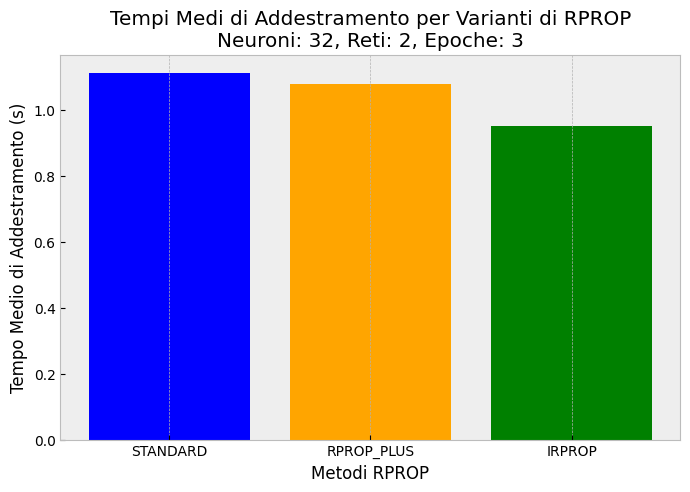

In [6]:
"""
    4. Valutazione delle Prestazioni con Grafici sul Tempo Medio di Addestramento, Errore Medio e Accuratezza media su Training e Validation Set 
"""
import os

path = f'results/[{num_of_networks}]Reti/{hidden_layers_sizes}Neuroni'

if not os.path.exists(path):
            os.makedirs(path)
            
# Creazione e stampa del grafico del tempo medio di addestramento 
plt.style.use('bmh')
plt.figure(figsize=(8, 5))
plt.bar(rprop_methods, average_training_times, color=['blue', 'orange', 'green'])
plt.title(f'Tempi Medi di Addestramento per Varianti di RPROP\n'
          f'Neuroni: {", ".join(map(str, hidden_layers_sizes))}, Reti: {num_of_networks}, Epoche: {epochs}')
plt.xlabel('Metodi RPROP')
plt.ylabel('Tempo Medio di Addestramento (s)')
plt.grid(axis='y')
plt.savefig(f'{path}/{",".join(map(str, hidden_layers_sizes))}_neuroni_{num_of_networks}_reti_{epochs}_epoche_tempo_medio_di_addestramento.png')
plt.show()
plt.close()

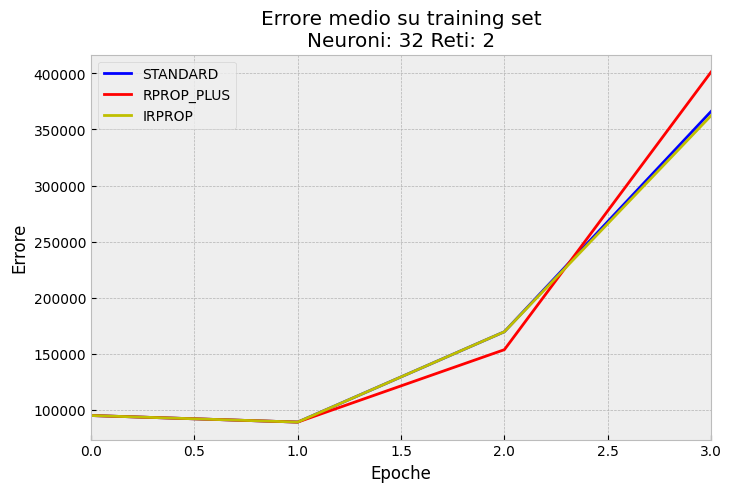

In [7]:
# Creazione e stampa del grafico dell'errore medio del training set
plt.style.use('bmh')
plt.figure(figsize=(8, 5))
plt.plot(std_metrics_mean[0], 'b', label='STANDARD')
plt.plot(plus_metrics_mean[0], 'r', label='RPROP_PLUS')
plt.plot(istd_metrics_mean[0], 'y', label='IRPROP')
plt.title(f'Errore medio su training set\nNeuroni: {", ".join(map(str, hidden_layers_sizes))} Reti: {num_of_networks}')
plt.xlabel('Epoche')
plt.ylabel('Errore')
plt.legend()
plt.grid(True)
plt.xlim(0, epochs)
plt.savefig(f'{path}/{",".join(map(str, hidden_layers_sizes))}_neuroni_errore_medio_training_set.png')
plt.show()
plt.close()

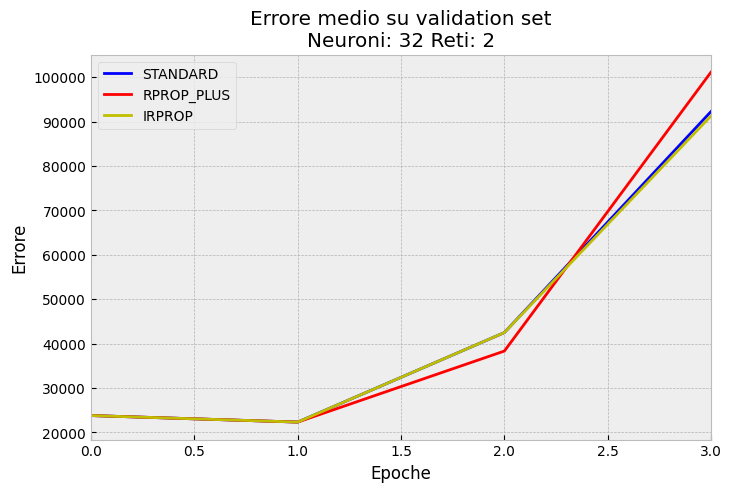

In [8]:
# Creazione e stampa del grafico dell'errore medio del validation set
plt.style.use('bmh')
plt.figure(figsize=(8, 5))
plt.plot(std_metrics_mean[1], 'b', label='STANDARD')
plt.plot(plus_metrics_mean[1], 'r', label='RPROP_PLUS')
plt.plot(istd_metrics_mean[1], 'y', label='IRPROP')
plt.title(f'Errore medio su validation set\nNeuroni: {", ".join(map(str, hidden_layers_sizes))} Reti: {num_of_networks}')
plt.xlabel('Epoche')
plt.ylabel('Errore')
plt.legend()
plt.grid(True)
plt.xlim(0, epochs)
plt.savefig(f'{path}/{",".join(map(str, hidden_layers_sizes))}_neuroni_errore_medio_validation_set.png')
plt.show()
plt.close()

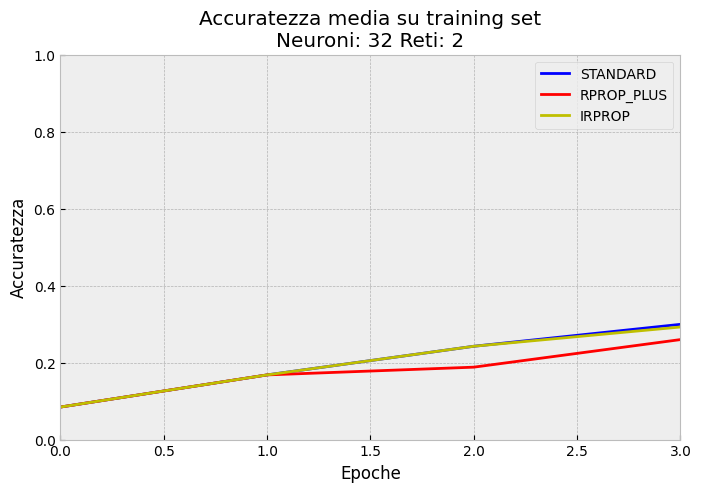

In [9]:
# Creazione e stampa del grafico dell'accuratezza media del training set
plt.style.use('bmh')
plt.figure(figsize=(8, 5))
plt.plot(std_metrics_mean[2], 'b', label='STANDARD')
plt.plot(plus_metrics_mean[2], 'r', label='RPROP_PLUS')
plt.plot(istd_metrics_mean[2], 'y', label='IRPROP')
plt.title(f'Accuratezza media su training set\nNeuroni: {", ".join(map(str, hidden_layers_sizes))} Reti: {num_of_networks}')
plt.xlabel('Epoche')
plt.ylabel('Accuratezza')
plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.xlim(0, epochs)
plt.savefig(f'{path}/{",".join(map(str, hidden_layers_sizes))}_neuroni_accuratezza_media_training_set.png')
plt.show()
plt.close()

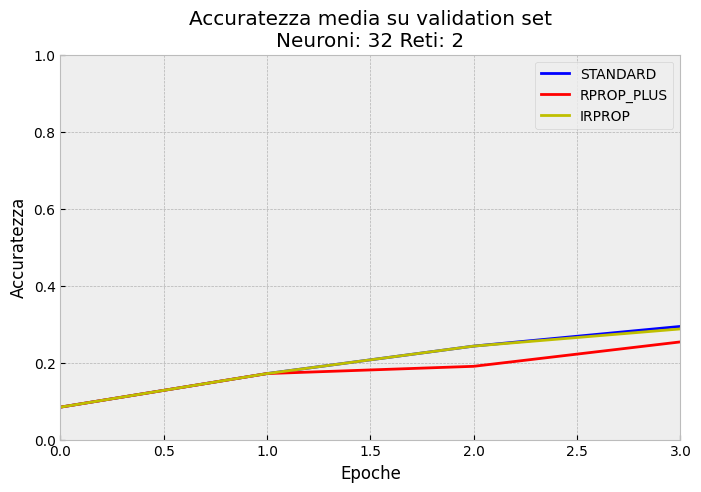

In [10]:
# Creazione e stampa del grafico dell'accuratezza media del validation set
plt.style.use('bmh')
plt.figure(figsize=(8, 5))
plt.plot(std_metrics_mean[3],  'b', label='STANDARD')
plt.plot(plus_metrics_mean[3], 'r', label='RPROP_PLUS')
plt.plot(istd_metrics_mean[3], 'y', label='IRPROP')
plt.title(f'Accuratezza media su validation set\nNeuroni: {", ".join(map(str, hidden_layers_sizes))} Reti: {num_of_networks}')
plt.xlabel('Epoche')
plt.ylabel('Accuratezza')
plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.xlim(0, epochs)
plt.savefig(f'{path}/{",".join(map(str, hidden_layers_sizes))}_neuroni_accuratezza_media_validation_set.png')
plt.show()
plt.close()